In [3]:
%matplotlib inline
import composeml as cp
import featuretools as ft

from demo.predict_rul import load_sample
from evalml import AutoMLSearch
from evalml.preprocessing import split_data

In [4]:
df = load_sample()

df.head()

,engine_no,time_in_cycles,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,time
id,,,,,,,,,,,,,,,,,,,,,
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670,2000-01-01 00:00:00
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552,2000-01-01 00:10:00
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213,2000-01-01 00:20:00
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176,2000-01-01 00:30:00
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754,2000-01-01 00:40:00


In [5]:
def remaining_useful_life(df):
    return len(df) - 1

In [6]:
lm = cp.LabelMaker(
    target_entity='engine_no',
    time_index='time',
    labeling_function=remaining_useful_life,
)

In [7]:
lt = lm.search(
    df.sort_values('time'),
    num_examples_per_instance=20,
    minimum_data=5,
    gap=20,
    verbose=True,
)

lt.head()

Elapsed: 00:00 | Remaining: 00:00 | Progress: 100%|██████████| engine_no: 80/80 


,engine_no,time,remaining_useful_life
0,1,2000-01-01 00:50:00,315
1,1,2000-01-01 04:10:00,295
2,1,2000-01-01 07:30:00,275
3,1,2000-01-01 10:50:00,255
4,1,2000-01-01 14:10:00,235


In [8]:
lt.describe()

Settings
--------
gap                                             20
minimum_data                                     5
num_examples_per_instance                       20
target_column                remaining_useful_life
target_entity                            engine_no
target_type                             continuous
window_size                                   None


Transforms
----------
No transforms applied



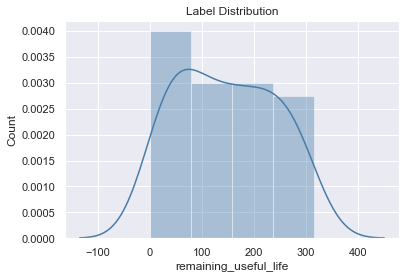

In [9]:
lt.plot.distribution();

In [10]:
lt = lt.bin(4, quantiles=True, precision=0)

In [11]:
lt.describe()

Label Distribution
------------------
(0.0, 64.0]       13
(141.0, 227.0]    12
(227.0, 315.0]    13
(64.0, 141.0]     13
Total:            51


Settings
--------
gap                                             20
minimum_data                                     5
num_examples_per_instance                       20
target_column                remaining_useful_life
target_entity                            engine_no
target_type                               discrete
window_size                                   None


Transforms
----------
1. bin
  - bins:            4
  - labels:       None
  - precision:       0
  - quantiles:    True
  - right:        True



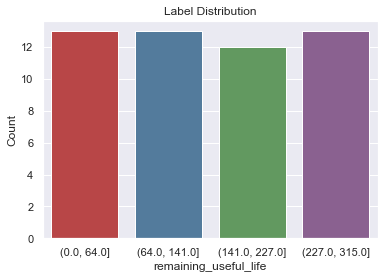

In [12]:
lt.plot.distribution();

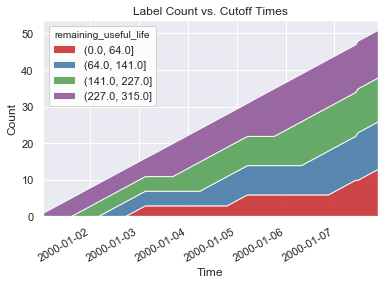

In [13]:
lt.plot.count_by_time();

In [14]:
es = ft.EntitySet('observations')

es.entity_from_dataframe(
    dataframe=df.reset_index(),
    entity_id='recordings',
    index='id',
    time_index='time',
)

es.normalize_entity(
    base_entity_id='recordings',
    new_entity_id='engines',
    index='engine_no',
)

es.normalize_entity(
    base_entity_id='recordings',
    new_entity_id='cycles',
    index='time_in_cycles',
)

Entityset: observations
  Entities:
    recordings [Rows: 1000, Columns: 28]
    engines [Rows: 4, Columns: 2]
    cycles [Rows: 321, Columns: 2]
  Relationships:
    recordings.engine_no -> engines.engine_no
    recordings.time_in_cycles -> cycles.time_in_cycles

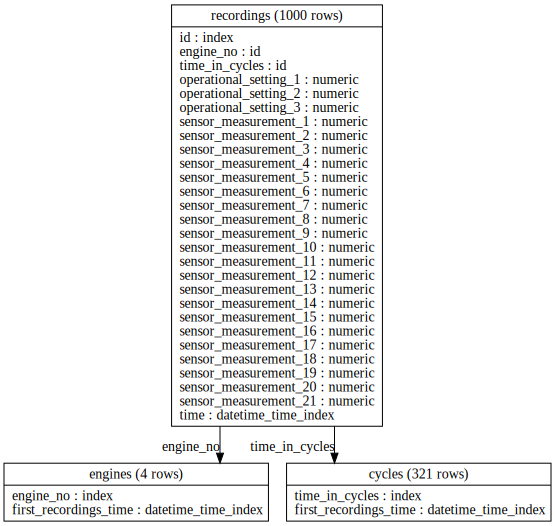

In [15]:
es.plot()

In [16]:
X, features = ft.dfs(
    entityset=es,
    target_entity='engines',
    agg_primitives=['sum'],
    trans_primitives=[],
    cutoff_time=lt,
    cutoff_time_in_index=True,
    include_cutoff_time=False,
    max_depth=3,
    verbose=True,
)

X.head()

Built 48 features
Elapsed: 00:06 | Progress: 100%|██████████


SUM(recordings.sensor_measurement_20)  \
engine_no time                                                         
1         2000-01-01 00:50:00                                  70.04   
          2000-01-01 04:10:00                                 490.85   
          2000-01-01 07:30:00                                 880.67   
          2000-01-01 10:50:00                                1312.52   
          2000-01-01 14:10:00                                1706.80   

                               SUM(recordings.sensor_measurement_5)  \
engine_no time                                                        
1         2000-01-01 00:50:00                                 28.13   
          2000-01-01 04:10:00                                193.41   
          2000-01-01 07:30:00                                349.26   
          2000-01-01 10:50:00                                514.70   
          2000-01-01 14:10:00                                663.76   

                               SUM(recordings.sensor_measurement_15)  \
engine_no time                                                         
1         2000-01-01 00:50:00                                48.0990   
          2000-01-01 04:10:00                               236.7149   
          2000-01-01 07:30:00                               428.9520   
          2000-01-01 10:50:00                               613.1760   
          2000-01-01 14:10:00                               797.0065   

                               SUM(recordings.sensor_measurement_2)  \
engine_no time                                                        
1         2000-01-01 00:50:00                               2789.50   
          2000-01-01 04:10:00                              14410.61   
          2000-01-01 07:30:00                              25813.75   
          2000-01-01 10:50:00                              37496.09   
          2000-01-01 14:10:00                              49063.70   

                               SUM(recordings.operational_setting_1)  \
engine_no time                                                         
1         2000-01-01 00:50:00                               171.0170   
          2000-01-01 04:10:00                               639.0537   
          2000-01-01 07:30:00                              1128.1028   
          2000-01-01 10:50:00                              1600.1473   
          2000-01-01 14:10:00                              2134.2039   

                               SUM(recordings.sensor_measurement_18)  \
engine_no time                                                         
1         2000-01-01 00:50:00                                  10875   
          2000-01-01 04:10:00                                  55256   
          2000-01-01 07:30:00                                  98671   
          2000-01-01 10:50:00                                 143705   
          2000-01-01 14:10:00                                 188802   

                               SUM(recordings.sensor_measurement_8)  \
engine_no time                                                        
1         2000-01-01 00:50:00                              10874.54   
          2000-01-01 04:10:00                              55252.70   
          2000-01-01 07:30:00                              98664.69   
          2000-01-01 10:50:00                             143694.65   
          2000-01-01 14:10:00                             188788.43   

                               SUM(recordings.sensor_measurement_9)  \
engine_no time                                                        
1         2000-01-01 00:50:00                              41638.90   
          2000-01-01 04:10:00                             211714.13   
          2000-01-01 07:30:00                             379760.09   
          2000-01-01 10:50:00                             550823.50   
          2000-01-01 14:10:00                             721240.61   

                   

In [17]:
y = X.pop('remaining_useful_life').cat.codes

y.head()

engine_no  time               
1          2000-01-01 00:50:00    3
           2000-01-01 04:10:00    3
           2000-01-01 07:30:00    3
           2000-01-01 10:50:00    3
           2000-01-01 14:10:00    3
dtype: int8

In [18]:
X_train, X_holdout, y_train, y_holdout = split_data(
    X=X,
    y=y,
    test_size=0.2,
    random_state=0,
)

In [19]:
automl = AutoMLSearch(
    problem_type='multiclass',
    objective='f1_macro',
    random_state=0,
)

automl.search(X_train, y_train, data_checks=None)

Using default limit of max_pipelines=5.

Generating pipelines to search over...
*****************************
* Beginning pipeline search *
*****************************

Optimizing for F1 Macro. 
Greater score is better.

Searching up to 5 pipelines. 
Allowed model families: catboost, xgboost, linear_model, random_forest



FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Best Score',
              'type'…

(1/5) Mode Baseline Multiclass Classificati... Elapsed:00:00
	Starting cross validation
	Finished cross validation - mean F1 Macro: 0.239
(2/5) CatBoost Classifier w/ Simple Imputer    Elapsed:00:00
	Starting cross validation
	Finished cross validation - mean F1 Macro: 0.752
(3/5) XGBoost Classifier w/ Simple Imputer     Elapsed:00:03
	Starting cross validation
	Finished cross validation - mean F1 Macro: 0.792
(4/5) Random Forest Classifier w/ Simple Im... Elapsed:00:04
	Starting cross validation
	Finished cross validation - mean F1 Macro: 0.773
(5/5) Logistic Regression Classifier w/ Sim... Elapsed:00:05
	Starting cross validation
	Finished cross validation - mean F1 Macro: 0.618

Search finished after 00:15            
Best pipeline: XGBoost Classifier w/ Simple Imputer
Best pipeline F1 Macro: 0.791534


****************************************
* XGBoost Classifier w/ Simple Imputer *
****************************************

Problem Type: Multiclass Classification
Model Family: XGBoost

Pipeline Steps
1. Simple Imputer
	 * impute_strategy : most_frequent
	 * fill_value : None
2. XGBoost Classifier
	 * eta : 0.1
	 * max_depth : 6
	 * min_child_weight : 1
	 * n_estimators : 100


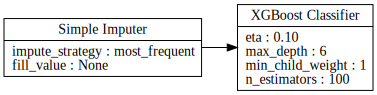

In [20]:
automl.best_pipeline.describe()
automl.best_pipeline.graph()

In [21]:
best_pipeline = automl.best_pipeline.fit(X_train, y_train)

score = best_pipeline.score(
    X=X_holdout,
    y=y_holdout,
    objectives=['f1_macro'],
)

dict(score)

{'F1 Macro': 0.9142857142857143}